In [8]:
import fermi.tipsh as tipsh
from astropy.wcs import WCS
from astropy.visualization.wcsaxes import WCSAxes
from astropy.wcs.wcsapi import SlicedLowLevelWCS
from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cartopy.crs as ccrs
from astropy.visualization.wcsaxes.frame import EllipticalFrame
import pywt
import numpy
import math
from scipy.stats import poisson
import fermi.rl as rl
import os
from importlib import reload
#reload(tipsh)
os.system("taskset -p 0xff %d" % os.getpid())

pid 4329's current affinity mask: ff
pid 4329's new affinity mask: ff


0

In [2]:
data_file = get_pkg_data_filename('/home/dave/fermi-data/lat_ultracleanveto_front_zmax90_1-2gev_ccube.fits')
point_model_file = get_pkg_data_filename('/home/dave/fermi-data/1-2gev_binned_point_model_map.fits')
diffuse_model_file = get_pkg_data_filename('/home/dave/fermi-data/1-2gev_binned_diffuse_model_map.fits')
galactic_model_file = get_pkg_data_filename('/home/dave/fermi-data/1-2gev_binned_galactic_diffuse_model_map.fits')
isotropic_model_file = get_pkg_data_filename('/home/dave/fermi-data/1-2gev_binned_isotropic_diffuse_model_map.fits')

In [3]:
count_cube = fits.getdata(data_file, ext=0)
count_data = count_cube[0]
point_model = fits.getdata(point_model_file, ext=0)
diffuse_model = fits.getdata(diffuse_model_file, ext=0)
galactic_model = fits.getdata(galactic_model_file, ext=0)
isotropic_model = fits.getdata(isotropic_model_file, ext=0)

In [4]:
dnorm = sum(sum(diffuse_model))
d = diffuse_model/dnorm
pnorm = sum(sum(point_model))
p = point_model/pnorm
gnorm = sum(sum(galactic_model))
g = galactic_model/gnorm
inorm = sum(sum(isotropic_model))
iso = isotropic_model/inorm

In [5]:
z0 = [dnorm, pnorm, gnorm, inorm]
psfs = [d, p, g, iso]
zk = z0

In [6]:
zk = rl.rl1(psfs, zk, count_data)
[i / j for i,j in zip(zk, z0)]

[0.9385084846799586,
 0.9499391766559807,
 0.9349412297486219,
 0.9445335421645259]

In [7]:
#def fz(z):
#    return loss(psfs, z, count_data, d2_loss_map)
#zknm = minimize(fz, zk, method='Nelder-Mead')

In [8]:
im0 = rl.image_conv(zk, psfs)
total_model = im0

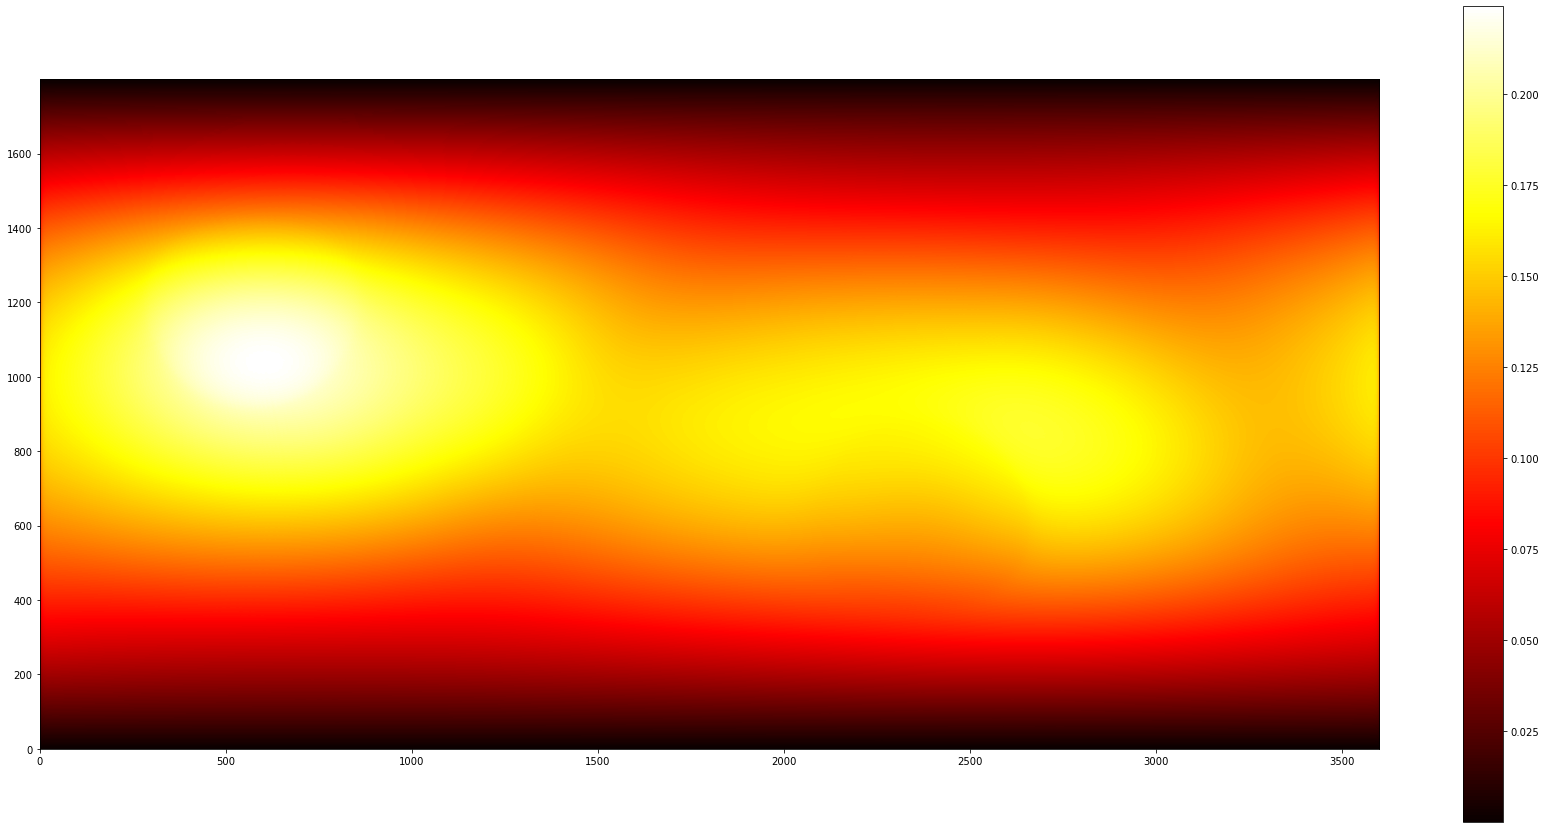

In [7]:
fig = plt.figure(figsize=(30, 15))
diff = plt.imshow(isotropic_model, cmap=plt.cm.hot, norm=colors.Normalize(), origin='lower')
plt.colorbar(diff)
#imshow_mollweide(diffuse_model, plt.cm.hot, colors.LogNorm())

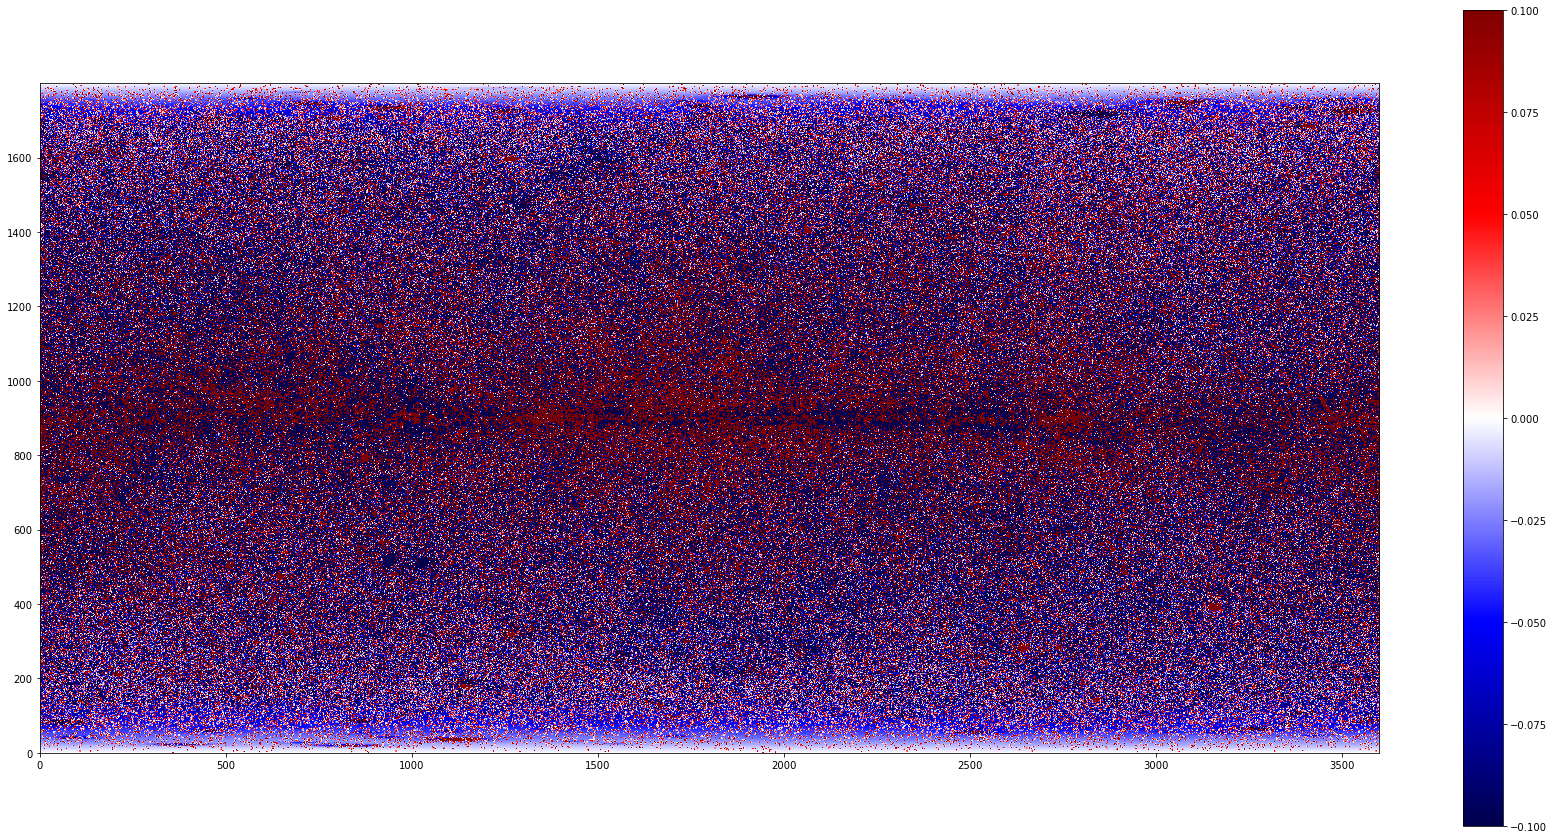

In [4]:
total_model = numpy.add(numpy.add(numpy.add(0.9*point_model, 1.0*diffuse_model), 0.925*galactic_model), 1.5*isotropic_model)
fig = plt.figure(figsize=(30, 15))
diff = plt.imshow(numpy.subtract(count_data, total_model), cmap=plt.cm.seismic, norm=colors.Normalize(vmin=-0.1,vmax=0.1), origin='lower')
plt.colorbar(diff)

In [5]:
def zero(n):
    return numpy.zeros((n,n), float)

def checkers(n, p):
    arr = numpy.zeros((n, 2*n), float) + 2
    for row in range(n):
        rq, rr = divmod(row, p)
        row_mult = 1 if rq % 2 == 0 else -1
        for col in range(2*n):
            cq, cr = divmod(col, p)
            col_mult = 1 if cq % 2 == 0 else -1
            arr[row,col] += row_mult*col_mult
    return arr

def delta(n, row, col):
    arr = numpy.zeros((n, 2*n), float) 
    arr[row, col] = 1
    return arr

def stripe(n, rows):
    arr = numpy.zeros((n, 2*n), float) 
    arr[rows, :] = 1
    return arr

In [32]:
total_model = stripe(30, [13,14,15])*100 + 1
data_model = total_model + stripe(30, [13,14,15])*20 #+ 20*delta(30, 15, 15)
count_data = poisson.rvs(data_model)
#a_model, hs_model, vs_model, ds_model = tipsh.haar_sphere(total_model)
#a_data, hs_data, vs_data, ds_data = haar(count_data)

In [33]:
#del a_model, hs_model, vs_model, ds_model
a_model, hs_model, vs_model, ds_model = tipsh.haar_sphere(total_model)
#del a, hs, vs, ds
a, hs, vs, ds = tipsh.haar_threshold_sphere(count_data, total_model, 0.00001, fwer='uniform')

6 5 1 ******************************
alpha_j 1e-05
sums
h threshold
small_left
small_right
v threshold
small_left
small_right
d threshold
small_left
small_right
5 -> Rejected 0 15 0
6 4 2 ******************************
alpha_j 1e-05
sums
h threshold
small_left
small_right
v threshold
small_left
small_right
d threshold
small_left
small_right
4 -> Rejected 0 292 0
6 3 4 ******************************
alpha_j 1e-05
sums
h threshold
small_left
small_right
large_left
large_right
v threshold
small_left
small_right
large_left
large_right
d threshold
small_left
small_right
large_left
large_right
3 -> Rejected 0 948 0
6 2 8 ******************************
alpha_j 1e-05
sums
h threshold
small_left
small_right
large_left
large_right
v threshold
small_left
small_right
large_left
large_right
d threshold
small_left
small_right
large_left
large_right
2 -> Rejected 0 2036 0
6 1 16 ******************************
alpha_j 1e-05
sums
h threshold
large_left
large_right
v threshold
large_left
large_right
d t

In [34]:
#del count_rec
count_rec = tipsh.inv_haar_sphere(a, hs, vs, ds)
print(sum(sum(count_data)), sum(sum(total_model)), sum(sum(count_rec)))

23393 19800.0 23393.0


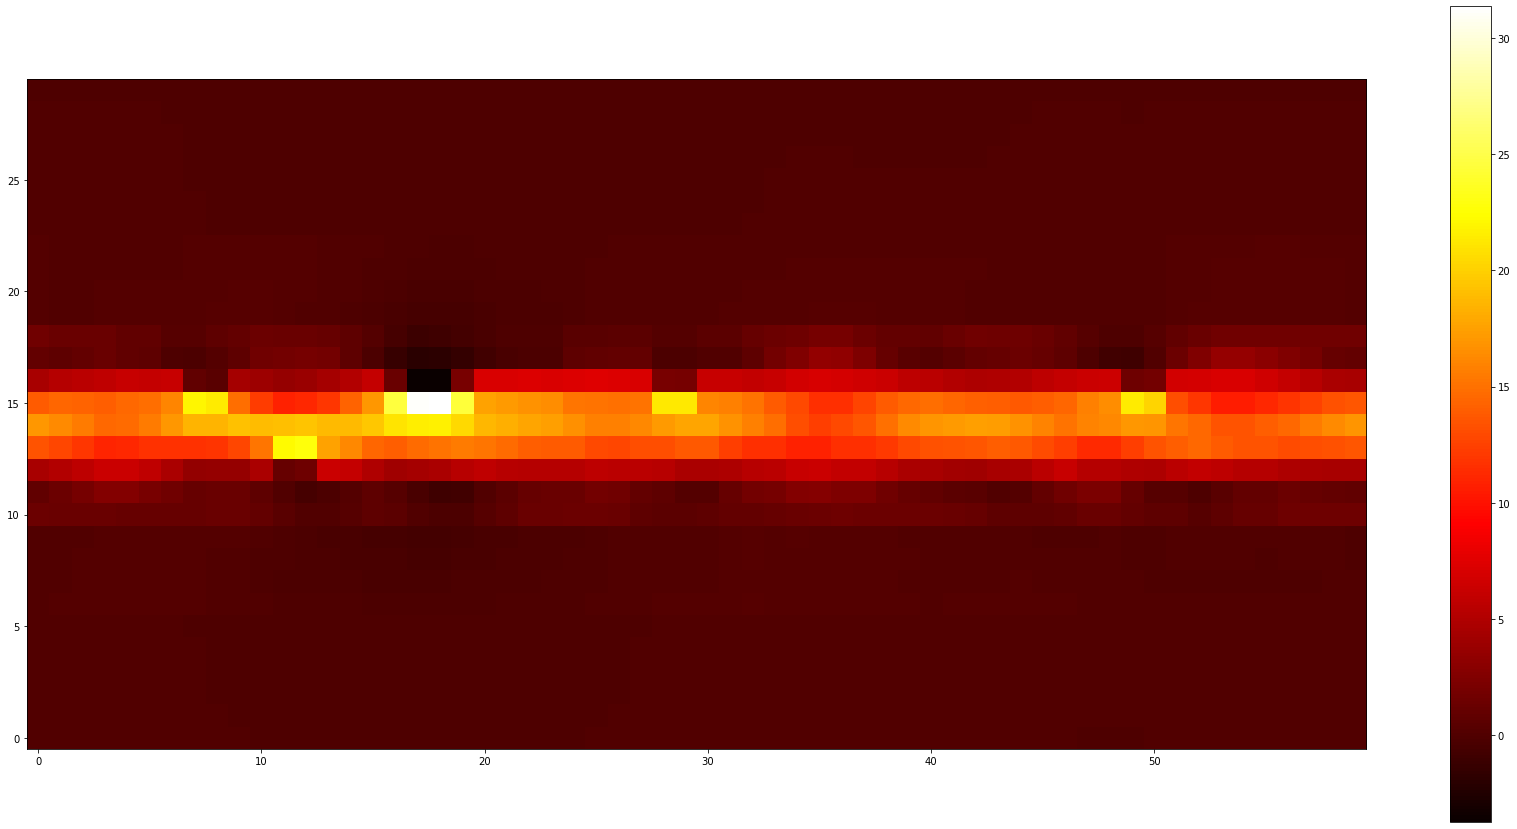

In [35]:
fig = plt.figure(figsize=(30, 15))
#diff = plt.imshow(numpy.subtract(count_rec, total_model), cmap=plt.cm.hot, norm=colors.Normalize(vmin=-0.1,vmax=0.6), origin='lower')
diff = plt.imshow(numpy.subtract(count_rec, total_model), cmap=plt.cm.hot, norm=colors.Normalize(), origin='lower')
#diff = plt.imshow(count_data, cmap=plt.cm.hot, origin='lower')

plt.colorbar(diff)

In [29]:
count_rec2_5 = count_rec

In [64]:
lon = numpy.arange(-180, 180, 0.1)
lat = numpy.arange(-90, 90, 0.1)
Lat, Lon = numpy.meshgrid(lon, lat)
levels = numpy.arange(-1, 5, 0.1)

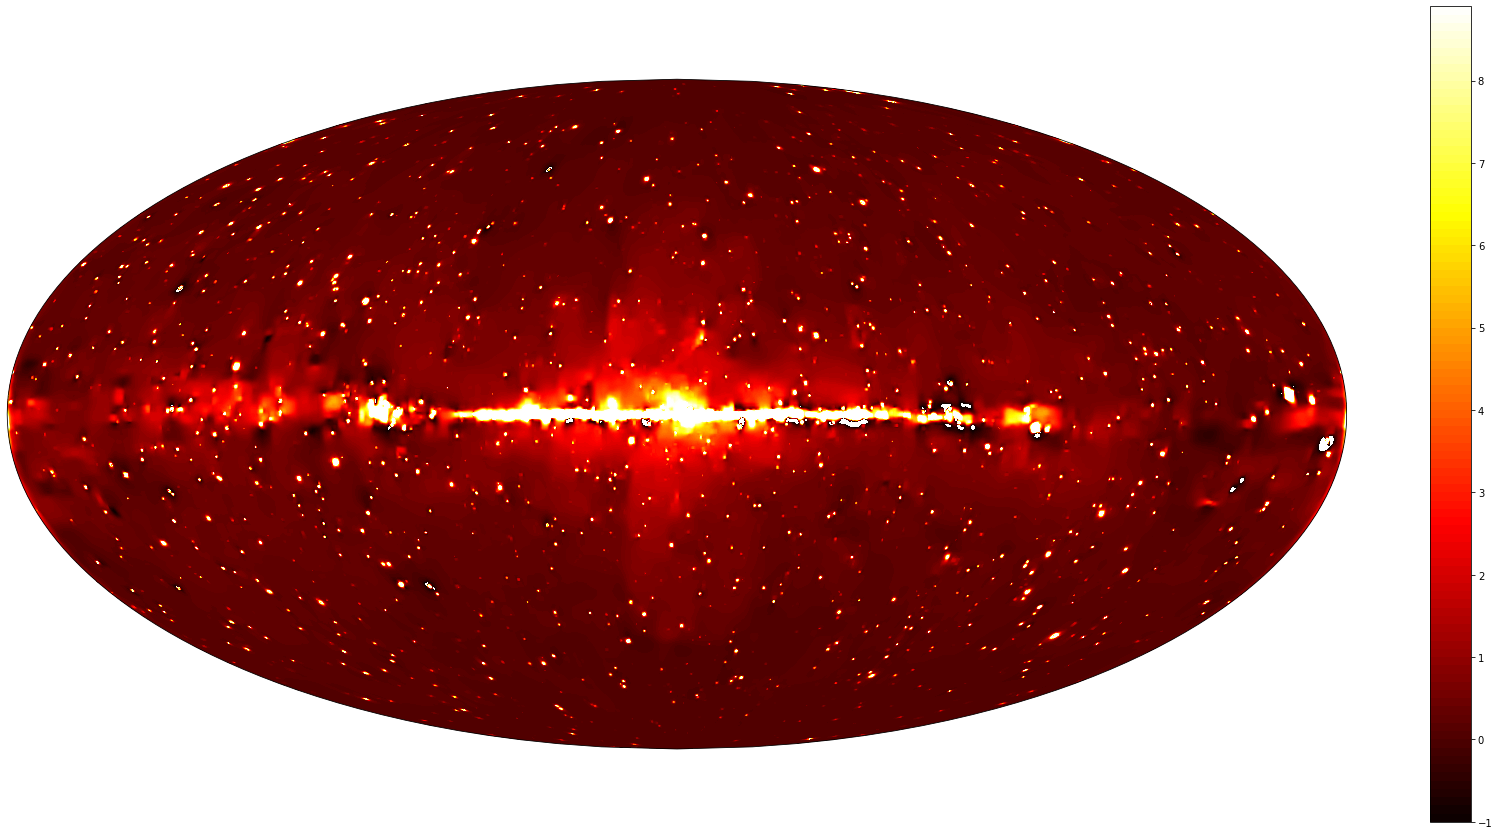

In [47]:
fig = plt.figure(figsize=(30, 15))
ax = plt.subplot(projection=ccrs.Mollweide())
foo = plt.contourf(Lat, Lon, numpy.subtract(count_rec, total_model), levels, cmap=plt.cm.hot, linewidths=0.3, transform=ccrs.PlateCarree())
plt.colorbar(foo)

In [36]:
#del a_diff, hs_diff, vs_diff, ds_diff
a_diff = numpy.subtract(a, a_model)
hs_diff = numpy.subtract(hs, hs_model)
vs_diff = numpy.subtract(vs, vs_model)
ds_diff = numpy.subtract(ds, ds_model)

In [30]:
#del a_model, hs_model, vs_model, ds_model

In [50]:
del rlev
rlev = tipsh.inv_haar_level(10, a_diff, hs_diff, vs_diff, ds_diff)

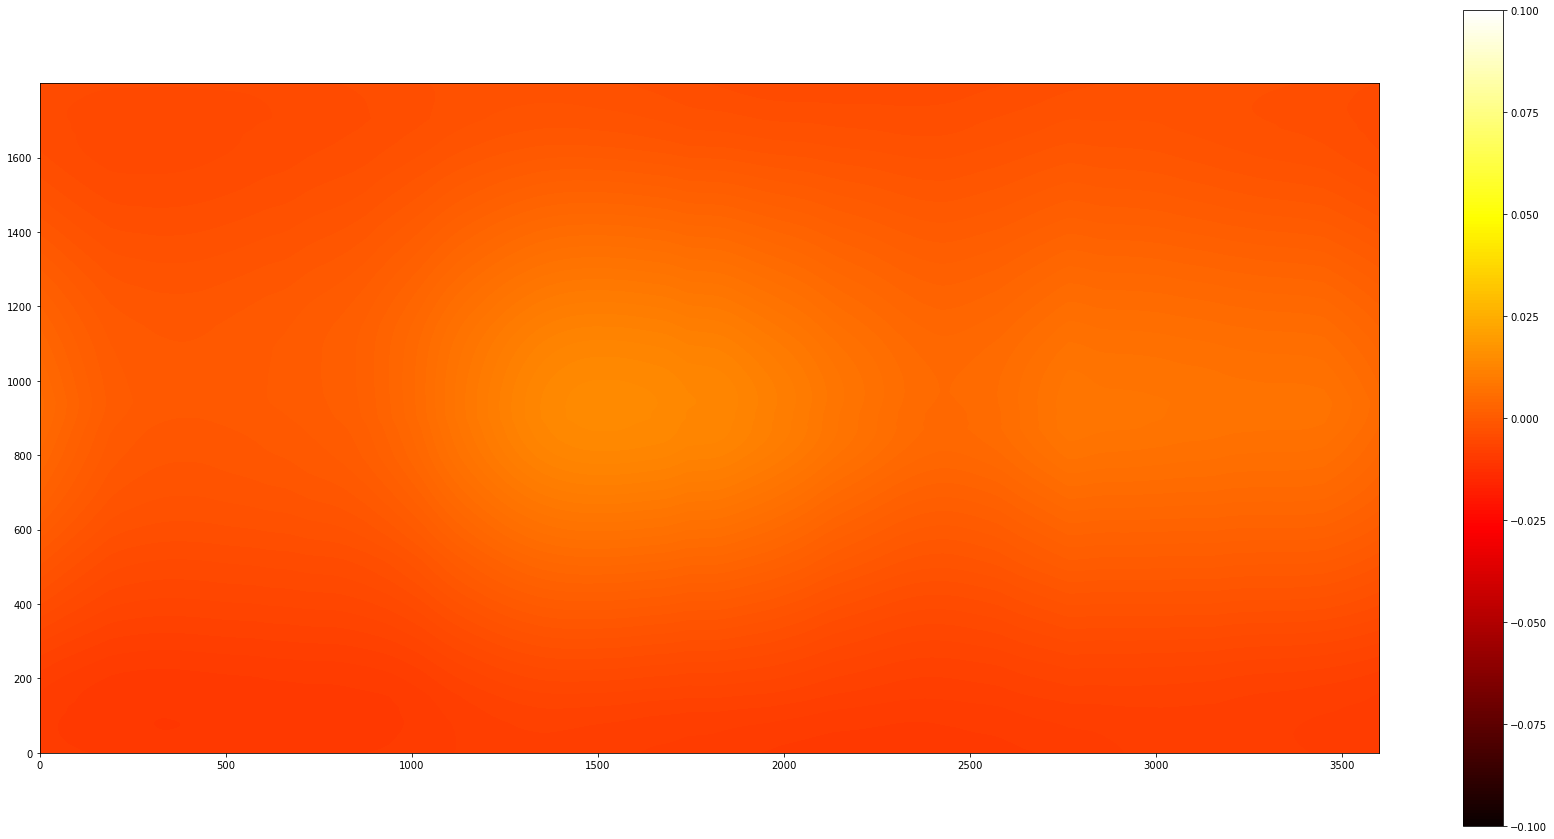

In [51]:
fig = plt.figure(figsize=(30, 15))
diff = plt.imshow(rlev, cmap=plt.cm.hot, norm=colors.Normalize(vmin=-0.1,vmax=0.1), origin='lower')
plt.colorbar(diff)

In [24]:
fig.savefig("2022-01-01_1_500_GeV_uniform_001.png")

R[write to console]: There were 50 or more warnings (use warnings() to see the first 50)
R[write to console]: 



In [23]:
numpy.savez_compressed("2022-01-01_uniform_001.npz", a=a,hs=hs,vs=vs,ds=ds)

In [40]:
numpy.savez_compressed("count_rec_2022-01-01_uniform_001.npz", count_rec=count_rec)

In [7]:
tmp = numpy.load("2022-01-01_uniform_000001.npz")
a = tmp['a']
hs = tmp['hs']
vs = tmp['vs']
ds = tmp['ds']

In [18]:
count_rec = numpy.load("count_rec_2022-01-01_uniform_000001.npz")['count_rec']

In [30]:
# Run this to release memory for GC
#del a, hs, vs, ds